# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df = pd.read_csv('../Data/MarineMicroplastics.csv')

In [3]:
df.head(2)

,FID,Date,Latitude,Longitude,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,...,Accession Number,Accession Link,GlobalID,CreationDate,Creator,EditDate,Editor,Long Reference,x,y
0,40055,4/3/2011 12:00:00 AM,-30.2413,-97.0948,Pacific Ocean,NaN,NaN,0.390376,pieces/m3,0.005-1,...,275968,https://www.ncei.noaa.gov/access/metadata/land...,4078602b-702b-4514-b625-4b08fb50d16c,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Eriksen, M., L.C.M. Lebreton, H.S. Carson, M. ...",-1.080854e+07,-3.534605e+06
1,39794,11/27/2010 12:00:00 AM,-33.5729,-13.7057,Atlantic Ocean,NaN,NaN,0.976803,pieces/m3,0.005-1,...,275968,https://www.ncei.noaa.gov/access/metadata/land...,fff505a7-d6da-435d-9b6e-8263bf448e78,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Eriksen, M., L.C.M. Lebreton, H.S. Carson, M. ...",-1.525712e+06,-3.971596e+06


# Preprocessing data

In [4]:
df.columns

Index(['FID', 'Date', 'Latitude', 'Longitude', 'Oceans', 'Regions',
       'SubRegions', 'Measurement', 'Unit', 'Density Range', 'Density Class',
       'Sampling Method', 'Short Reference', 'DOI', 'Organization', 'Keywords',
       'Accession Number', 'Accession Link', 'GlobalID', 'CreationDate',
       'Creator', 'EditDate', 'Editor', 'Long Reference', 'x', 'y'],
      dtype='object')

In [5]:
df.dtypes

FID                   int64
Date                 object
Latitude            float64
Longitude           float64
Oceans               object
Regions              object
SubRegions           object
Measurement         float64
Unit                 object
Density Range        object
Density Class        object
Sampling Method      object
Short Reference      object
DOI                  object
Organization         object
Keywords             object
Accession Number      int64
Accession Link       object
GlobalID             object
CreationDate         object
Creator              object
EditDate             object
Editor               object
Long Reference       object
x                   float64
y                   float64
dtype: object

In [6]:
# Set index as a time series
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head(1)

,FID,Latitude,Longitude,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,Density Class,...,Accession Number,Accession Link,GlobalID,CreationDate,Creator,EditDate,Editor,Long Reference,x,y
Date,,,,,,,,,,,,,,,,,,,,,
1972-04-20,40541,39.0,-141.017,Pacific Ocean,NaN,NaN,0.017,pieces/m3,0.005-1,Medium,...,253448,https://www.ncei.noaa.gov/access/metadata/land...,cd81c3c8-9fd5-4743-8aa7-b73bdbdd92e0,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Goldstein, M.C., A.J. Titmus, M. Ford. 2013. S...",-1.569794e+07,4.721672e+06


# Train test split

In [7]:
df.columns

Index(['FID', 'Latitude', 'Longitude', 'Oceans', 'Regions', 'SubRegions',
       'Measurement', 'Unit', 'Density Range', 'Density Class',
       'Sampling Method', 'Short Reference', 'DOI', 'Organization', 'Keywords',
       'Accession Number', 'Accession Link', 'GlobalID', 'CreationDate',
       'Creator', 'EditDate', 'Editor', 'Long Reference', 'x', 'y'],
      dtype='object')

The columns were using are latitude and longitude because that more or less describes the ocean, region, and subregion. We noticed a significant difference in sample concentrations based on the sampling method, so theoretically that should be able to predict microplastic concentrations.

In [8]:
X = df[['Latitude','Longitude', 'Sampling Method']]
y= df[['Measurement']].values

In [9]:
#dropping nans until we get a cleaner data set
X = X.dropna().copy()

In [10]:
#Waiting to get clean data before using cat variables
X = pd.get_dummies(data = X, columns = ['Sampling Method'], drop_first = True)

In [11]:
X_train, X_test, y_train, y_test= train_test_split(X, y, shuffle = False)

In [12]:
X_train.head(15)

,Latitude,Longitude,Sampling Method_Aluminum bucket,Sampling Method_Grab sample,Sampling Method_Intake seawater,Sampling Method_Manta net,Sampling Method_Neuston net,Sampling Method_Plankton net,Sampling Method_Stainless steel bucket,Sampling Method_Surface water intake
Date,,,,,,,,,,
1972-04-20,39.000,-141.017,0,0,0,0,1,0,0,0
1972-04-25,35.617,-127.900,0,0,0,0,1,0,0,0
1972-04-26,35.000,-128.967,0,0,0,0,1,0,0,0
1972-04-27,34.983,-133.083,0,0,0,0,1,0,0,0
1972-04-28,34.983,-137.050,0,0,0,0,1,0,0,0
1972-04-29,34.950,-141.000,0,0,0,0,1,0,0,0
1972-05-02,39.000,-135.000,0,0,0,0,1,0,0,0
1972-05-02,39.000,-132.983,0,0,0,0,1,0,0,0
1972-05-03,37.333,-129.283,0,0,0,0,1,0,0,0


## Scaling data


Normally we need to scale, but here we have mostly dummy variables except for our latitude and longitude which shouldn't be scaled.


# Time series generator

This portion referred to the  [RNN lesson](https://git.generalassemb.ly/dsir-0320/8.05-lesson-rnn/blob/main/starter_code_Hank_dsir_0320.ipynb)

In [29]:
train_sequences = TimeseriesGenerator(X_train, y_train, length = 1, batch_size = 32)

In [30]:
batch_x, batch_y = train_sequences[0]

print(batch_x.shape)
print(batch_y.shape)

(32, 1, 10)
(32, 1)


In [31]:
test_sequences = TimeseriesGenerator(X_test, y_test, length = 1, batch_size = 32)

# Modeling

In [16]:
input_shape = train_sequences[0][0][0].shape

In [35]:
model = Sequential()

model.add(GRU(64, input_shape=input_shape, return_sequences = True,kernel_regularizer=l2(0.015))) 
model.add(GRU(16, return_sequences = False)) 
model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.005))
model.add(Dense(8, activation = 'relu'))
# output layer
model.add(Dense(1, activation = 'sigmoid'))

In [36]:
model.compile(loss = 'mse',
              optimizer = Adam(learning_rate = 0.35),
              metrics = ['acc'])

history = model.fit(train_sequences,
                    validation_data = test_sequences,
                    epochs = 10)

Epoch 1/10
327/327 [==============================] - 21s 36ms/step - loss: 11.8457 - acc: 0.3842 - val_loss: 1127046.0000 - val_acc: 0.1105
Epoch 2/10
327/327 [==============================] - 9s 28ms/step - loss: 11.8132 - acc: 0.3859 - val_loss: 1127046.0000 - val_acc: 0.1105
Epoch 3/10
327/327 [==============================] - 9s 29ms/step - loss: 11.8132 - acc: 0.3859 - val_loss: 1127046.0000 - val_acc: 0.1105
Epoch 4/10
327/327 [==============================] - 10s 29ms/step - loss: 11.8133 - acc: 0.3859 - val_loss: 1127046.0000 - val_acc: 0.1105
Epoch 5/10
327/327 [==============================] - 9s 29ms/step - loss: 11.8184 - acc: 0.3859 - val_loss: 1127046.0000 - val_acc: 0.1105
Epoch 6/10
327/327 [==============================] - 10s 30ms/step - loss: 11.8163 - acc: 0.3859 - val_loss: 1127046.0000 - val_acc: 0.1105
Epoch 7/10
327/327 [==============================] - 10s 31ms/step - loss: 11.8162 - acc: 0.3859 - val_loss: 1127046.1250 - val_acc: 0.1105
Epoch 8/10
327/3

 For our initial results, we had a training accuracy of .08 and a validation accuracy of 0. After changing some features we are getting a training accuracy of .38 and a validation accuracy of .11. It appears that the model isn't learning anything new with each epoch. Will need accurately reconvene with the team for suggestions.

There may not be enough features to accurately predict future concentrations of plastic.

In [19]:
df['Measurement'].mean()

19.875032848873904

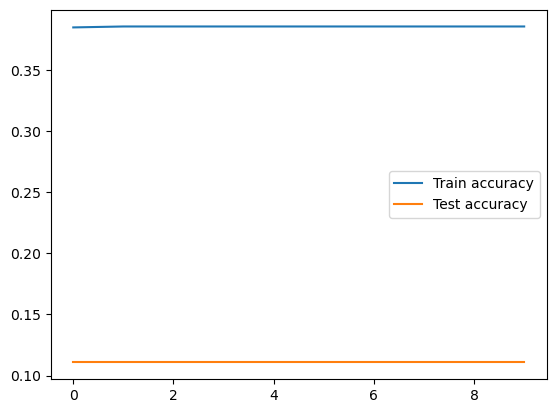

In [20]:
#plotting accuracy

plt.plot(history.history['acc'], label = 'Train accuracy')
plt.plot(history.history['val_acc'], label = 'Test accuracy')
plt.legend();